In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install -r "/content/drive/MyDrive/handwritten-text-recognition/requirements.txt"

     |████████████████████████████████| 46.9MB 90kB/s 
     |████████████████████████████████| 348kB 21.9MB/s 
     |████████████████████████████████| 51kB 4.4MB/s 
     |████████████████████████████████| 901kB 38.2MB/s 
     |████████████████████████████████| 163kB 45.7MB/s 
  Created wheel for leven: filename=leven-1.0.4-cp37-cp37m-linux_x86_64.whl size=55467 sha256=92d66e6c9ad55f0a04f8a357d742b3b7cb9cec7ad855f7113a68391d60b6b99b
  Stored in directory: /root/.cache/pip/wheels/54/64/a5/439db671d666a50f3b3cebd2dcab3fbbab02785adf58e47552
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595683 sha256=df8aa9bec18f6235873851c91a6eec883190d6c3322fd027a10682de68a9ebda
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built leven gluonnlp
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
!pip install pdf2image

In [71]:
!apt install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.12 [154 kB]
Fetched 154 kB in 2s (65.9 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.12_amd64.deb ...
Unpacking poppler-utils (0.62.0-2ubuntu2.12) ...
Setting up poppler-utils (0.62.0-2ubuntu2.12) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!mkdir '/content/drive/MyDrive/images'

In [72]:
#The pdf2image library can be used
#You can install it simply using,


#Once installed you can use following code to get images.
from pdf2image import convert_from_path
pages = convert_from_path('/content/drive/MyDrive/answer sheets pdf/test.pdf', 500)

#Saving pages in jpeg format
cnt=0
for i,page in enumerate(pages):
    y="/content/drive/MyDrive/images/"+str(i)+"im.jpeg"
    page.save(y, 'JPEG')
    cnt+=1
print(cnt)

1


In [78]:
import cv2
import glob
import numpy as np
from PIL import Image

images = []
files = glob.glob ("/content/drive/MyDrive/images/*.jpeg")
for myFile in files:
    print(myFile)
    image = Image.open(myFile)
    new_image = image.resize((2479, 3542))
    new_image.save(myFile)
    image = cv2.imread(myFile, cv2.IMREAD_GRAYSCALE)
    images.append (image)
imag=np.array(images)
print(' shape:', imag.shape)

/content/drive/MyDrive/images/images.jpeg
/content/drive/MyDrive/images/with_triangle.jpeg
/content/drive/MyDrive/images/0im.jpeg
 shape: (3, 3542, 2479)


In [4]:
%cd /content/drive/MyDrive/handwritten-text-recognition

/content/drive/MyDrive/handwritten-text-recognition


In [5]:
import difflib
import importlib
import math
import random
import string

random.seed(123)

import gluonnlp as nlp
import leven
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
from skimage import transform as skimage_tf, exposure
from tqdm import tqdm

from ocr.utils.expand_bounding_box import expand_bounding_box
from ocr.utils.sclite_helper import ScliteHelper
from ocr.utils.word_to_line import sort_bbs_line_by_line, crop_line_images
from ocr.utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from ocr.utils.encoder_decoder import Denoiser, ALPHABET, encode_char, decode_char, EOS, BOS
from ocr.utils.beam_search import ctcBeamSearch

import ocr.utils.denoiser_utils
import ocr.utils.beam_search

importlib.reload(ocr.utils.denoiser_utils)
from ocr.utils.denoiser_utils import SequenceGenerator

importlib.reload(ocr.utils.beam_search)
from ocr.utils.beam_search import ctcBeamSearch


from ocr.paragraph_segmentation_dcnn import SegmentationNetwork, paragraph_segmentation_transform
from ocr.word_and_line_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from ocr.handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from ocr.handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding

In [6]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()

In [7]:
random.seed(1)

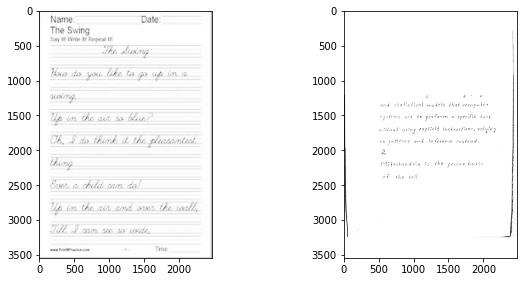

In [79]:
plt.figure(figsize=(10,10)) # specifying the overall grid size

for i in range(cnt):
    plt.subplot(2,2,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(imag[i], cmap='Greys_r')

#plt.show()

In [57]:
paragraph_segmentation_net = SegmentationNetwork(ctx=ctx)
print("One",paragraph_segmentation_net)
paragraph_segmentation_net.cnn.load_parameters("models/paragraph_segmentation2.params", ctx=ctx)
print("Two",paragraph_segmentation_net)

One SegmentationNetwork(
  (cnn): HybridSequential(
    (0): Conv2D(1 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (2): Activation(relu)
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (4): HybridSequential(
      (0): BasicBlockV1(
        (body): HybridSequential(
          (0): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
          (2): Activation(relu)
          (3): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
        )
      )
      (1): BasicBlockV1(
        (body): H

In [10]:
paragraph_segmentation_net.hybridize()

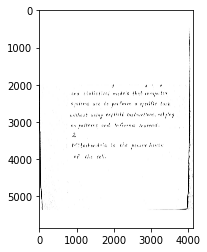

In [75]:
import cv2
import numpy
img = cv2.imread("/content/drive/MyDrive/images/0im.jpeg")
triangle = numpy.array([[0, 0], [4000, 0], [4000, 2000],[0, 2000]])
color = [255, 255, 255] #white
cv2.fillConvexPoly(img, triangle, color)
cv2.imwrite("/content/drive/MyDrive/images/with_triangle.jpeg", img)
plt.imshow(img, cmap='Greys_r')

(3542, 2479)
One 
[[0.12711373 0.23011164 0.82341063 0.4829786 ]]
<NDArray 1x4 @cpu(0)>
Two [0.12711373 0.23011164 0.82341063 0.4829786 ]
(3542, 2479)
One 
[[0.16271019 0.2582174  0.7530298  0.37533465]]
<NDArray 1x4 @cpu(0)>
Two [0.16271019 0.2582174  0.7530298  0.37533465]
(3542, 2479)
One 
[[0.15096207 0.25026664 0.77681977 0.40259025]]
<NDArray 1x4 @cpu(0)>
Two [0.15096207 0.25026664 0.77681977 0.40259025]


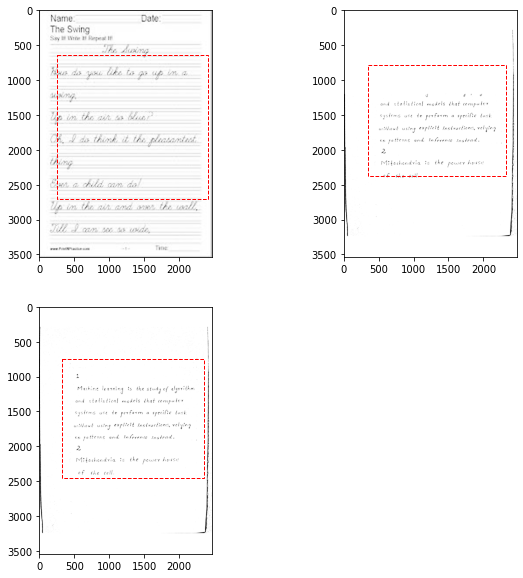

In [80]:
from matplotlib.patches import Rectangle
form_size = (1120, 800)

predicted_bbs = []
plt.figure(figsize=(10,10)) # specifying the overall grid size
#fig, axs = plt.subplots(int(len(imag)/2), 2, figsize=(15, 9 * len(imag)/2))
for i, image in enumerate(imag):
  print(image.shape)
  #s_y, s_x = int(i/2), int(i%2)
  resized_image = paragraph_segmentation_transform(image, form_size)
  bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
  print("One",bb_predicted)
  bb_predicted = bb_predicted[0].asnumpy()
  print("Two",bb_predicted)
  bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.06, expand_bb_scale_y=0.2)
  predicted_bbs.append(bb_predicted)
    
  #axs[s_y, s_x].imshow(image, cmap='Greys_r')
  #axs[s_y, s_x].set_title("{}".format(i))

  (x, y, w, h) = bb_predicted
  image_h, image_w = image.shape[-2:]
  (x, y, w, h) = (x * image_w+1, y * image_h+1, w * image_w+1, h * image_h+1)
  rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
  #axs[s_y, s_x].add_patch(rect)
  

  plt.subplot(2,2,i+1)    # the number of images in the grid is 5*5 (25)
  plt.imshow(imag[i], cmap='Greys_r')
  plt.gca().add_patch(rect)
  #axs[s_y, s_x].axis('off')


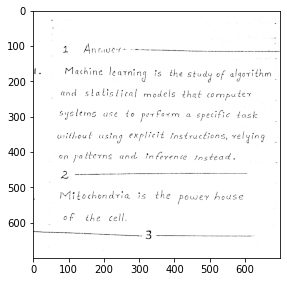

In [ ]:
segmented_paragraph_size = (700, 700)
#fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
plt.figure(figsize=(10,10))
paragraph_segmented_images = []

for i, image in enumerate(images):
    #s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)
    plt.subplot(2,2,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(image, cmap='Greys_r')
    #axs[s_y, s_x].imshow(image, cmap='Greys_r')
    #axs[s_y, s_x].axis('off')

In [ ]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation2.params")
word_segmentation_net.hybridize()

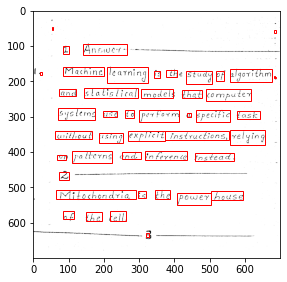

In [ ]:
min_c = 0.1
overlap_thres = 0.1
topk = 600
plt.figure(figsize=(10,10))
#fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    #s_y, s_x = int(i/2), int(i%2)
    predicted_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)
    predicted_words_bbs_array.append(predicted_bb)
    #axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    plt.subplot(2,2,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(paragraph_segmented_image, cmap='Greys_r')
    for j in range(predicted_bb.shape[0]):     
        (x, y, w, h) = predicted_bb[j]
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        plt.gca().add_patch(rect)
        #axs[s_y, s_x].add_patch(rect)
        #axs[s_y, s_x].axis('off')

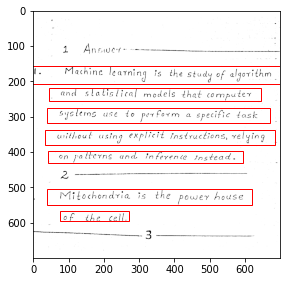

In [ ]:
line_images_array = []
#fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))
plt.figure(figsize=(10,10))
for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    #s_y, s_x = int(i/2), int(i%2)
    #axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    #axs[s_y, s_x].axis('off')
    #axs[s_y, s_x].set_title("{}".format(i))
    plt.subplot(2,2,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(paragraph_segmented_image, cmap='Greys_r')
    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    line_images_array.append(line_images)
    
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        plt.gca().add_patch(rect)
        #axs[s_y, s_x].add_patch(rect)

In [ ]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("models/handwriting_line8.params", ctx=ctx)
handwriting_line_recognition_net.hybridize()

In [ ]:
line_image_size = (60, 800)
character_probs = []
for line_images in line_images_array:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        form_character_prob.append(line_character_prob)
    character_probs.append(form_character_prob)

In [ ]:
#greedy algorithm convert the output of the handwriting recognition network into strings
def get_arg_max(prob): 
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

In [ ]:
def get_beam_search(prob, width=5):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width)
    return possibilities[0]

In [ ]:
FEATURE_LEN = 150
denoiser = Denoiser(alphabet_size=len(ALPHABET), max_src_length=FEATURE_LEN, max_tgt_length=FEATURE_LEN, num_heads=16, embed_size=256, num_layers=2)
denoiser.load_parameters('models/denoiser2.params', ctx=ctx)

In [ ]:
denoiser.hybridize(static_alloc=True)

In [ ]:
 #https://apache-mxnet.s3-accelerate.dualstack.amazonaws.com/gluon/dataset/vocab/gbw-ebb1a287.zip...
 #https://apache-mxnet.s3-accelerate.dualstack.amazonaws.com/gluon/models/big_rnn_lm_2048_512_gbw-6bb3e991.zip...

In [ ]:
ctx_nlp = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()
language_model, vocab = nlp.model.big_rnn_lm_2048_512(dataset_name='gbw', vocab='/content/drive/MyDrive/gbw-ebb1a287.vocab', pretrained=True, ctx=ctx_nlp)
moses_tokenizer = nlp.data.SacreMosesTokenizer()
moses_detokenizer = nlp.data.SacreMosesDetokenizer()

/usr/local/lib/python3.7/dist-packages/gluonnlp/model/utils.py:268: UserWarning: Both dataset_name and vocab are specified. Loading vocab based on dataset_name. Input "vocab" argument will be ignored.
  warnings.warn('Both dataset_name and vocab are specified. '


Vocab file is not found. Downloading.


In [ ]:
print(language_model)
print(vocab)

BigRNN(
  (embedding): HybridSequential(
    (0): Embedding(793471 -> 512, float32)
    (1): Dropout(p = 0.1, axes=())
  )
  (encoder): HybridSequentialRNNCell(
  (0): LSTMPCell(512 -> 8192 -> 512)
  (1): DropoutCell(rate=0.1, axes=())
  )
  (decoder): Dense(512 -> 793471, linear)
)
Vocab(size=793471, unk="<unk>", reserved="['<pad>', '<eos>']")


In [ ]:
beam_sampler = nlp.model.BeamSearchSampler(beam_size=20,
                                           decoder=denoiser.decode_logprob,
                                           eos_id=EOS,
                                           scorer=nlp.model.BeamSearchScorer(),
                                           max_length=150)

In [ ]:
#!unzip '/content/drive/MyDrive/gbw-ebb1a287.zip' -c 

In [ ]:
generator = SequenceGenerator(beam_sampler, language_model, vocab, ctx_nlp, moses_tokenizer, moses_detokenizer)

In [ ]:
def get_denoised(prob, ctc_bs=False):
    if ctc_bs: # Using ctc beam search before denoising yields only limited improvements a is very slow
        text = get_beam_search(prob)
    else:
        text = get_arg_max(prob)
    src_seq, src_valid_length = encode_char(text)
    src_seq = mx.nd.array([src_seq], ctx=ctx)
    src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
    encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
    states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                      encoder_valid_length=src_valid_length)
    inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
    output = generator.generate_sequences(inputs, states, text)[::2]
    return output.strip()

In [ ]:
sentence = "This sentnce has an eror"
src_seq, src_valid_length = encode_char(sentence)
#print(src_seq,src_valid_length)
src_seq = mx.nd.array([src_seq], ctx=ctx)
src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                  encoder_valid_length=src_valid_length)
inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
print(sentence)
print("Choice")
print(generator.generate_sequences(inputs, states, sentence)[::2])

This sentnce has an eror
Choice
This sentence as an error


[AM] 1.. Machin leatning is the study of algowithmn.
[D ] Mr. Marchin learning is the study of algo within.
[AM] and slalislical models that computex
[D ] and stalistical models that computer
[AM] syslemns mfe to perform a specific task
[D ] systems me to perform a specific task
[AM] withoul using explicit instructions, relying.
[D ] without using explicit instructions, relying.
[AM] 'on palterns anch in fertence instead.
[D ] on patterns arch in fertence instead.
[AM] Mitachondria is the power house
[D ] Milachondra is the power house
[AM] of the Cell.
[D ] o h el


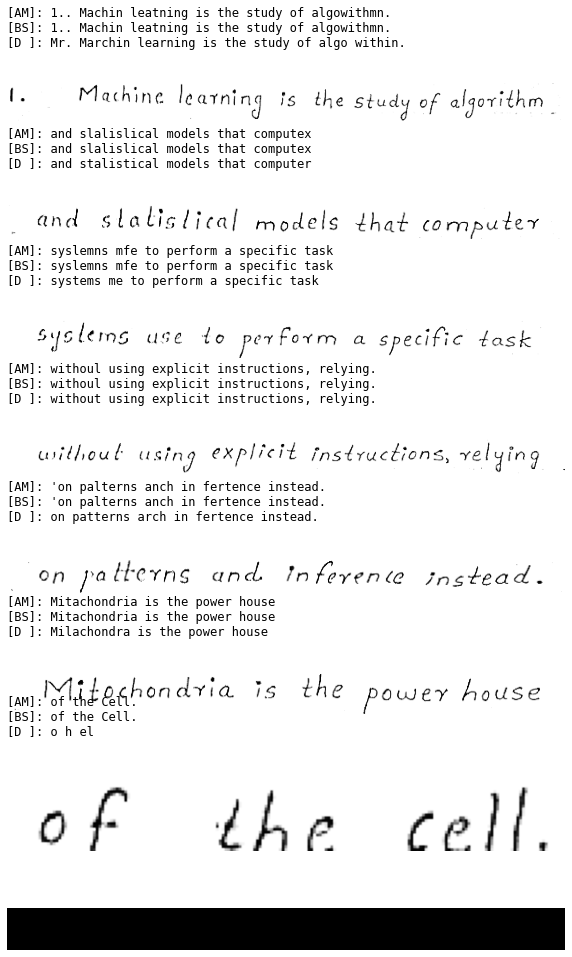

In [ ]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(10, int(1 + 2.3 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line_am = get_arg_max(line_character_probs)
        print("[AM]",decoded_line_am)
        decoded_line_bs = get_beam_search(line_character_probs)
        decoded_line_denoiser = get_denoised(line_character_probs, ctc_bs=False)
        print("[D ]",decoded_line_denoiser)
        
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].set_title("[AM]: {}\n[BS]: {}\n[D ]: {}\n\n".format(decoded_line_am, decoded_line_bs, decoded_line_denoiser), fontdict={"horizontalalignment":"left", "family":"monospace"}, x=0)
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

In [ ]:
for i, form_character_probs in enumerate(character_probs):
    ans=""
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line_am = get_arg_max(line_character_probs)
        decoded_line_bs = get_beam_search(line_character_probs)
        decoded_line_denoiser = get_denoised(line_character_probs, ctc_bs=False)
        #print("[D ]",decoded_line_denoiser)
        ans+=" "
        ans+=decoded_line_denoiser
    print("Answer",i+1," :")
    print(ans)   

Answer 1  :
 Mr. Marchin learning is the study of algo within. and stalistical models that computer systems me to perform a specific task without using explicit instructions, relying. on patterns arch in fertence instead. Milachondra is the power house o h el


[P] I hove to stop Mr. Gaitskell from
[P] nominating any more Labour life Peers
[P] is to be made at a meeting of Labour
[P] MPs tomorrow. Mr. Michael Foot has
[P] put down a resolution on the subject
[P] and he is to be backed by Mr. Will
[P] Griffiths, M P for Manchester Exchange
[P] The presence of 75 of bismueth-ano is equiralent to
[P] inyrowth over two half-lives (ten days). Therefore
[P] after a further fordy days, the bismuth daughter
[P] will be withimn of sources are required for use sconer
[P] than fordy a fifty days after preparation, the
[P] lead-aro together with added lead carrier must
[P] be separated from the bismuth-awo daughter by
[P] ion exchange lsee Analytical Methed, steps u.3)
[P] before preipitating lead chromate.
[P] Amateur radio also known as. Hom Madic
[P] doesnot refer to special kind of radio I
[P] t2 2 Spacial set of muiles whtch apply to
[P] (eTtain Frequencies as actimed by the
[P] Inkernational "Feiecommunications unitor and
[P] regulated n India by w

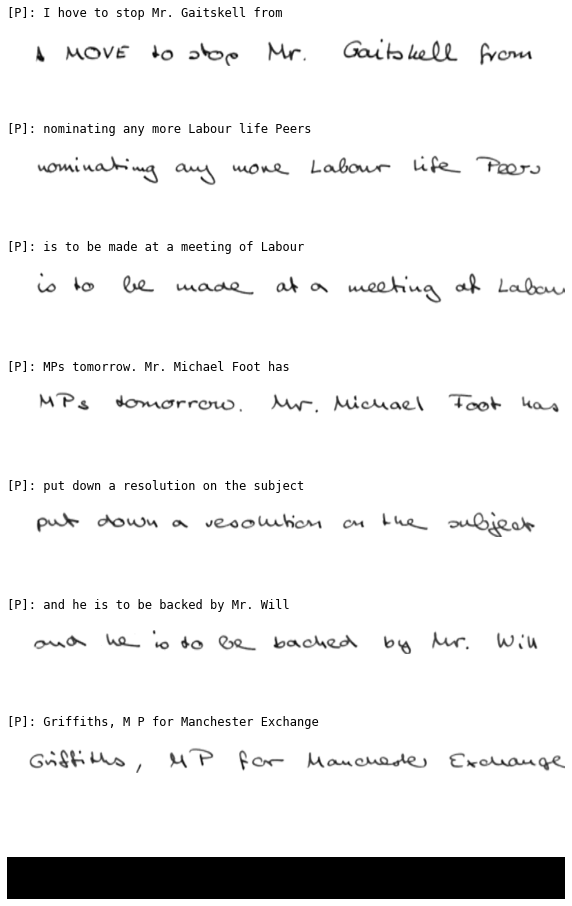

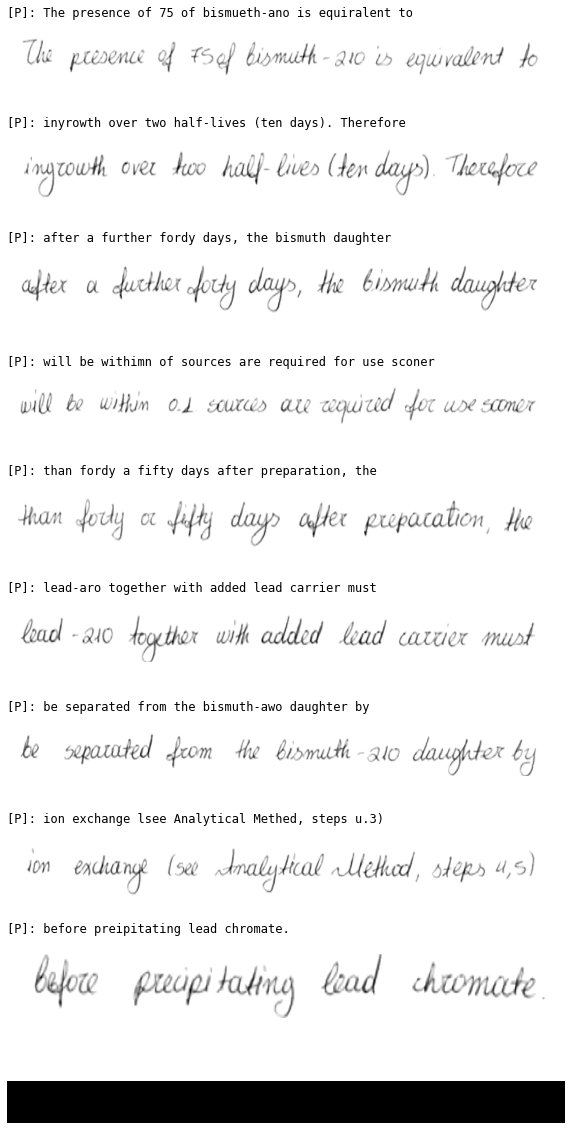

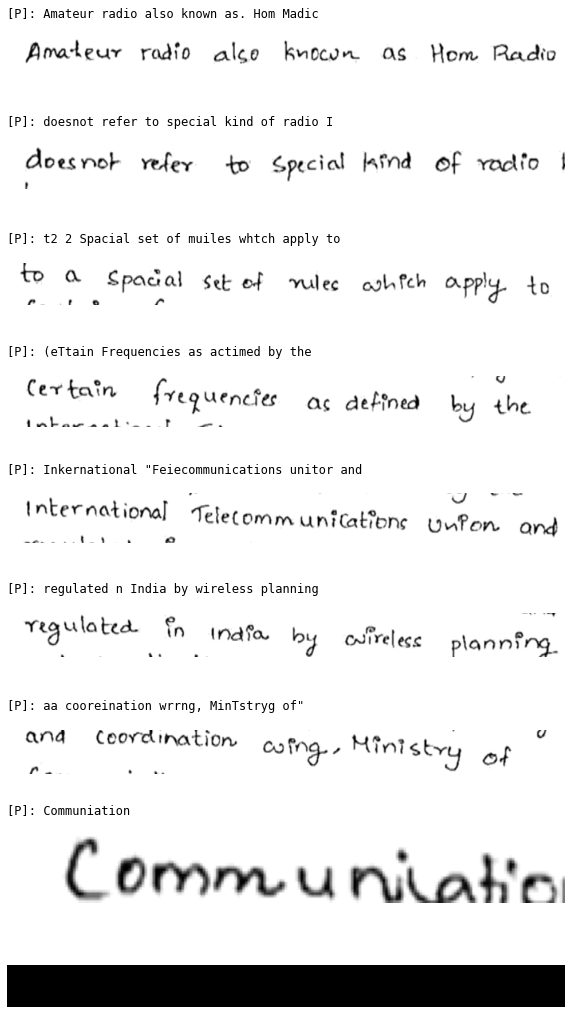

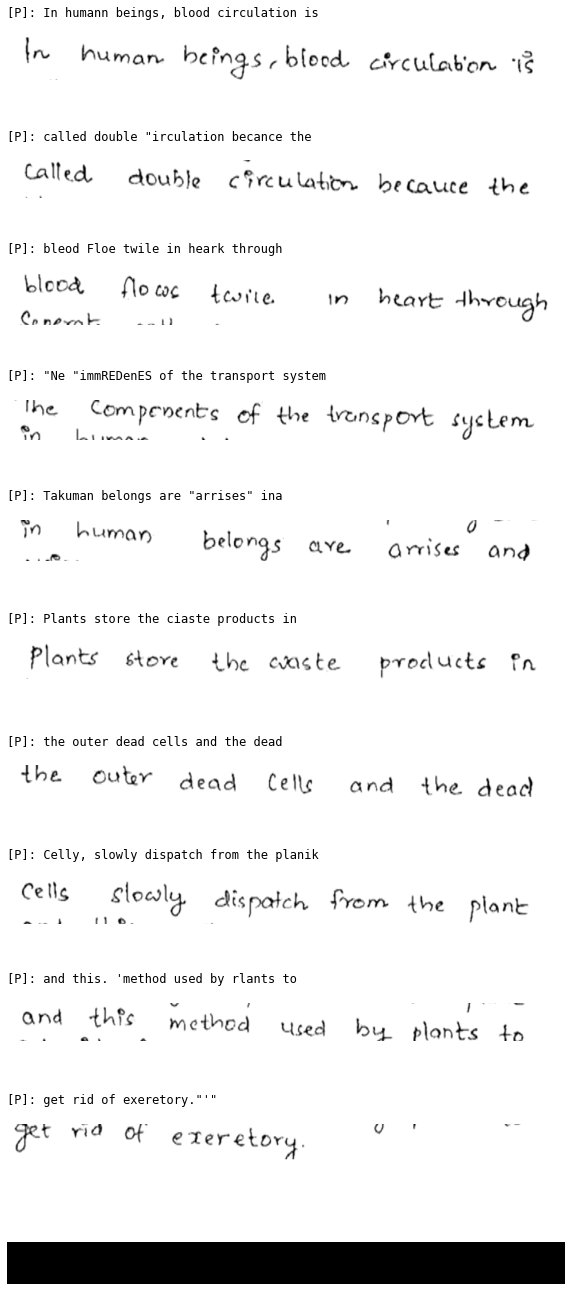

In [ ]:
 for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(10, int(1 + 2.3 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line_am = get_arg_max(line_character_probs)
        print("[P]",decoded_line_am)       
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].set_title("[P]: {}\n".format(decoded_line_am), fontdict={"horizontalalignment":"left", "family":"monospace"}, x=0)
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

In [ ]:
#delete images folder
#!find . -maxdepth 1 -type f -name "*.jpeg" -exec rm '/content/drive/MyDrive/images/';
!rm -r "/content/drive/MyDrive/images/"

Text answer stored into DATABASE table named answer_db